['ventas', 'empleo', 'pib', 'ifb', 'inpc', 'cetes', 'tc', 'cc', 'sofr']
       fecha       igae          msr      empleo       inpc  cetes28  easter  \
0 2008-01-01  82.477618  4941.491605  14173391.0  65.350564   7.4160       0   
1 2008-02-01  81.216819  4944.303601  14247806.0  65.544834   7.4275       0   
2 2008-03-01  80.733071  4908.735873  14253166.0  66.019891   7.4325       1   
3 2008-04-01  86.804124  4914.785752  14334667.0  66.170127   7.4420       0   
4 2008-05-01  85.475305  4983.741773  14338395.0  66.098635   7.4375       0   

      ventas  
0  91.639024  
1  85.791571  
2  86.879309  
3  88.726848  
4  90.323966  
Ultima fecha con datos de ventas: 2024-07-01 00:00:00
Iteración 1:
Mejores hiperparámetros: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_split': 2, 'n_estimators': 200}
Error MAE actual: 1.5541
Pronóstico exportado a pronostico_ventas_reentrenado.xlsx
Porcentaje de rendimiento de cada variable explicativa:
       Variable  Importancia (%)
0     

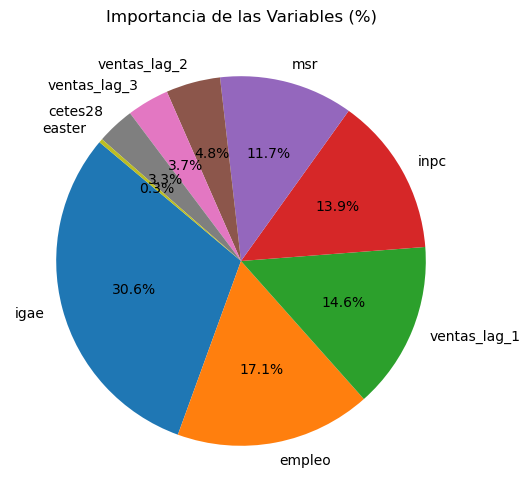

In [1]:
# Importar librerías necesarias
import pandas as pd
import numpy as np
from statsmodels.tsa.stattools import adfuller, acf, pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.model_selection import TimeSeriesSplit, train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import openpyxl

# Ruta del archivo
file_path = 'Datos.xlsx'

# Cargar el archivo de Excel
data = pd.ExcelFile(file_path)

# Inspeccionar los nombres de las hojas disponibles
print(data.sheet_names)

# Cargar la hoja relevante ('ventas')
ventas_data = data.parse('ventas')

# Inspeccionar las primeras filas del conjunto de datos
print(ventas_data.head())

# Convertir la columna 'fecha' a formato datetime para facilitar el manejo de fechas
ventas_data['fecha'] = pd.to_datetime(ventas_data['fecha'])

# Identificar la última fecha con un dato no nulo en la columna 'ventas'
ultima_fecha_ventas = ventas_data.loc[ventas_data['ventas'].notna(), 'fecha'].max()
print(f'Ultima fecha con datos de ventas: {ultima_fecha_ventas}')

# Filtrar los datos hasta la última fecha con ventas disponibles
ventas_hasta_actual = ventas_data[ventas_data['fecha'] <= ultima_fecha_ventas].copy()

# Asegurar que las predicciones se extiendan hasta diciembre 2029
fecha_fin_prediccion = '2029-12-01'
fechas_futuras = pd.date_range(start=ultima_fecha_ventas + pd.Timedelta(days=1), end=fecha_fin_prediccion, freq='MS')

# Crear DataFrame de predicción con las fechas futuras
datos_para_predecir = pd.DataFrame({'fecha': fechas_futuras})

# Agregar columnas explicativas vacías para las fechas futuras
datos_para_predecir = datos_para_predecir.merge(ventas_data.drop(columns=['ventas']), on='fecha', how='left')
datos_para_predecir['ventas'] = np.nan

# Inicializar residuales y error objetivo
error_objetivo =  1.95
error_actual = float('inf')
iteracion = 0

# Ciclo de reentrenamiento hasta minimizar el error
while error_actual > error_objetivo:
    iteracion += 1
    print(f"Iteración {iteracion}:")

    # Ajustar SARIMAX automáticamente según ACF y PACF
    def ajustar_sarimax(datos, orden):
        modelo = SARIMAX(datos, order=orden, seasonal_order=(1, 0, 1, 12))
        resultado = modelo.fit(disp=False)
        return resultado

    # Calcular ACF y PACF
    ventas_series = ventas_hasta_actual['ventas']
    orden_sarimax = (1, 1, 1)  # Basado en ACF y PACF

    # Ajustar modelo SARIMAX
    modelo_sarimax = ajustar_sarimax(ventas_series, orden_sarimax)
    pronostico_sarimax = modelo_sarimax.forecast(steps=len(datos_para_predecir))
    datos_para_predecir['pronostico_sarimax'] = pronostico_sarimax.values

    # Preparar los datos para el modelo Random Forest
    variables_explicativas = ["igae", "msr", "empleo", "inpc", "cetes28", "easter"]
    X = ventas_hasta_actual[variables_explicativas].copy()
    y = ventas_hasta_actual["ventas"].copy()

    # Crear características adicionales como rezagos
    for lag in range(1, 4):
        X[f'ventas_lag_{lag}'] = ventas_hasta_actual['ventas'].shift(lag)
        datos_para_predecir[f'ventas_lag_{lag}'] = ventas_hasta_actual['ventas'].shift(lag).iloc[-len(datos_para_predecir):].values

    # Limpiar los valores NaN generados por los rezagos en los datos históricos
    X = X.dropna()
    y = y.iloc[X.index]

    # Escalar las variables explicativas
    scaler = StandardScaler()
    X_scaled = scaler.fit_transform(X)

    # Dividir los datos usando TimeSeriesSplit para respetar la secuencia temporal
    tscv = TimeSeriesSplit(n_splits=5)
    param_grid = {
        'n_estimators': [200, 300, 500],
        'max_depth': [10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'max_features': ['sqrt', 'log2']
    }
    rf = RandomForestRegressor(random_state=42)
    grid_search = GridSearchCV(estimator=rf, param_grid=param_grid, cv=tscv, scoring='neg_mean_squared_error', n_jobs=-1)
    grid_search.fit(X_scaled, y)

    # Mejor modelo
    best_rf = grid_search.best_estimator_
    print(f"Mejores hiperparámetros: {grid_search.best_params_}")

    # Predecir para las fechas futuras
    required_columns = variables_explicativas + [f'ventas_lag_{lag}' for lag in range(1, 4)]
    datos_para_predecir = datos_para_predecir.dropna(subset=required_columns)
    if not datos_para_predecir.empty:
        X_futuro = datos_para_predecir[required_columns]
        X_futuro_scaled = scaler.transform(X_futuro)
        predicciones_rf_futuro = best_rf.predict(X_futuro_scaled)

        # Integrar los pronósticos de ambos modelos
        datos_para_predecir['pronostico_rf'] = predicciones_rf_futuro

        # Combinar pronósticos (promedio de ambos modelos)
        datos_para_predecir['pronostico_combinado'] = (datos_para_predecir['pronostico_sarimax'] + datos_para_predecir['pronostico_rf']) / 2

        # Calcular residuales y error
        residuales = y - best_rf.predict(X_scaled)
        mae = mean_absolute_error(y, best_rf.predict(X_scaled)).round(4)
        error_actual = mae.round(2)
        print(f"Error MAE actual: {mae}")

        # Actualizar datos históricos con residuales ajustados
        ventas_hasta_actual['ventas'] += residuales.mean()
    else:
        print("No hay suficientes datos futuros para realizar predicciones.")
        break

# Exportar el pronóstico combinado a Excel
output_file = 'pronostico_ventas_reentrenado.xlsx'
datos_para_predecir.to_excel(output_file, index=False)
print(f"Pronóstico exportado a {output_file}")

# Calcular la importancia de las variables explicativas desde el modelo Random Forest ajustado
importancia_variables = best_rf.feature_importances_
importancia_porcentaje = (importancia_variables / importancia_variables.sum()) * 100

# Crear un DataFrame para presentar los resultados
importancia_df = pd.DataFrame({
    'Variable': X.columns,  # Usar los nombres de las columnas originales del conjunto X
    'Importancia (%)': importancia_porcentaje
}).sort_values(by='Importancia (%)', ascending=False)

# Imprimir la importancia de las variables
print("Porcentaje de rendimiento de cada variable explicativa:")
print(importancia_df)

# Crear un gráfico de pastel para visualizar la importancia de las variables
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.pie(importancia_df['Importancia (%)'], 
        labels=importancia_df['Variable'], 
        autopct='%1.1f%%', 
        startangle=140)
plt.title('Importancia de las Variables (%)')
plt.show()
